# 2.1 Import Libraries 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
newstopwords = ['rt', 'https', 'http', 'co',  'amp', 'vaccine', 'covid','vaccinate', 'vaccination', 'people', 'coronavirus','want', 'still', 'know', 'make', 'vaccinated', 'vaccines', 'u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
stop_words.extend(newstopwords)
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import torch
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,Dense,SpatialDropout1D,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import numpy as np # linear algebra
import re
import string
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(17,13))
import seaborn as sns
sns.set_style('darkgrid')

import collections
from collections import Counter
import scipy.stats as stats

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

import warnings
warnings.filterwarnings("ignore")
print("Library Setup Complete.")

Library Setup Complete.


In [4]:
df = pd.read_csv('../Dataset/cleaned_dataset.csv', encoding = "utf-8")
df.drop("Unnamed: 0",axis=1,inplace=True)

In [5]:
print(df.shape)
df.head()

(12877, 2)


,text,is_misinfo
0,"My 87 year old grandmother has been quarantining in her Florida house for close to a year. She was so excited to go to @CityDaytona to get her COVID vaccine next week, only to find out @CountyOfVolusia only has 2000 doses spread out over 2 days. For a county of 500,000+. 1/3",0
1,I’m so excited that with this vaccine I can see the day where we get back to the work of thanking and celebrating (in person and face to face) all the amazing work our healthcare heroes do every day. I’m very ready to throw our “Pandemic is over” party! #417fightscovid https://t.co/T7O6ypn8Ax,0
2,So excited that I was able to close out 2020 on a positive note with getting the first dose of the COVID-19 vaccine! https://t.co/Y1mSXVPBMD,0
3,"Well, it happened. My daughter used my grandchildren to try to guilt me in to taking the vaccine for the CCP bioweapon. Satan is disguised in so many forms. Be on your guard...even when it feels like your heart is being ripped out. #StandStrong 🙏🏾",1
4,"I’m getting my COVID-19 vaccine, baby! I’m so fucking excited!",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12877 entries, 0 to 12876
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        12877 non-null  object
 1   is_misinfo  12877 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 201.3+ KB


# 2.2 Is the Data Balanced?

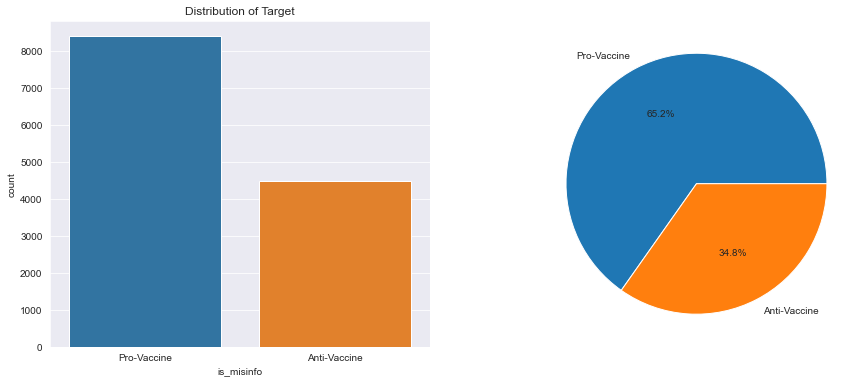

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x=df['is_misinfo'])
plt.xticks([0,1], ['Pro-Vaccine','Anti-Vaccine'])
plt.title('Distribution of Target')

plt.subplot(1,2,2)
pro_vac = df[df['is_misinfo']==0].shape[0]
anti_vac = df[df['is_misinfo']==1].shape[0]
plt.pie([pro_vac, anti_vac], labels = ['Pro-Vaccine', 'Anti-Vaccine'], autopct='%1.1f%%')

plt.show()

# 2.3 Distribution of Number of Words 

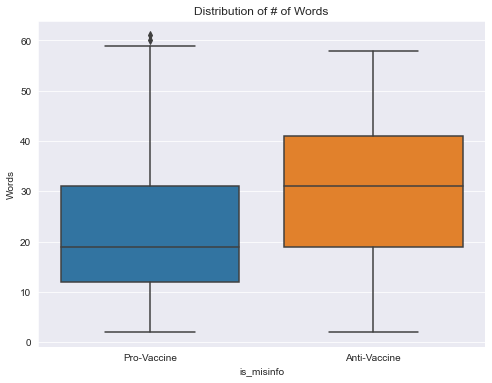

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(x = df['is_misinfo'], y=df['text'].str.split().apply(lambda x: len(x)))
plt.title('Distribution of # of Words')
plt.xticks(ticks=[0,1],labels = ['Pro-Vaccine', 'Anti-Vaccine'])
plt.ylabel('Words')
plt.show()

In [9]:
stats.f_oneway(df[df['is_misinfo']==0]['text'].str.split().apply(lambda x: len(x)),
               df[df['is_misinfo']==1]['text'].str.split().apply(lambda x: len(x)))

F_onewayResult(statistic=1081.5857926254666, pvalue=7.652907009238765e-228)

##### Since  p_val > .05 we accept H0 and conclude there is no difference in means.

# 2.4 Pre-Processing 

In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [17]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [18]:
df['clean_text'] = df['text'].apply(lambda x: clean_text(x))

In [19]:
df.head()

,text,is_misinfo,clean_text
0,"My 87 year old grandmother has been quarantining in her Florida house for close to a year. She was so excited to go to @CityDaytona to get her COVID vaccine next week, only to find out @CountyOfVolusia only has 2000 doses spread out over 2 days. For a county of 500,000+. 1/3",0,year old grandmother quarantine florida house close year excite go citydaytona get next week find countyofvolusia dose spread day county
1,I’m so excited that with this vaccine I can see the day where we get back to the work of thanking and celebrating (in person and face to face) all the amazing work our healthcare heroes do every day. I’m very ready to throw our “Pandemic is over” party! #417fightscovid https://t.co/T7O6ypn8Ax,0,excite see day get back work thank celebrate person face face amazing work healthcare hero every day ready throw pandemic party
2,So excited that I was able to close out 2020 on a positive note with getting the first dose of the COVID-19 vaccine! https://t.co/Y1mSXVPBMD,0,excite able close positive note get first dose
3,"Well, it happened. My daughter used my grandchildren to try to guilt me in to taking the vaccine for the CCP bioweapon. Satan is disguised in so many forms. Be on your guard...even when it feels like your heart is being ripped out. #StandStrong 🙏🏾",1,well happen daughter use grandchild try guilt take ccp bioweapon satan disguise many form guardeven feel like heart rip standstrong
4,"I’m getting my COVID-19 vaccine, baby! I’m so fucking excited!",0,get baby fuck excited


In [42]:
df.head(40)

,text,is_misinfo,clean_text
0,"My 87 year old grandmother has been quarantining in her Florida house for close to a year. She was so excited to go to @CityDaytona to get her COVID vaccine next week, only to find out @CountyOfVolusia only has 2000 doses spread out over 2 days. For a county of 500,000+. 1/3",0,year old grandmother quarantine florida house close year excite go citydaytona get next week find countyofvolusia dose spread day county
1,I’m so excited that with this vaccine I can see the day where we get back to the work of thanking and celebrating (in person and face to face) all the amazing work our healthcare heroes do every day. I’m very ready to throw our “Pandemic is over” party! #417fightscovid https://t.co/T7O6ypn8Ax,0,excite see day get back work thank celebrate person face face amazing work healthcare hero every day ready throw pandemic party
2,So excited that I was able to close out 2020 on a positive note with getting the first dose of the COVID-19 vaccine! https://t.co/Y1mSXVPBMD,0,excite able close positive note get first dose
3,"Well, it happened. My daughter used my grandchildren to try to guilt me in to taking the vaccine for the CCP bioweapon. Satan is disguised in so many forms. Be on your guard...even when it feels like your heart is being ripped out. #StandStrong 🙏🏾",1,well happen daughter use grandchild try guilt take ccp bioweapon satan disguise many form guardeven feel like heart rip standstrong
4,"I’m getting my COVID-19 vaccine, baby! I’m so fucking excited!",0,get baby fuck excited
5,"Hmmm. For #Idaho, 56,225 #covid vaccines available and only 15,780 administered? Not even 30%. Seems like there isn't a high demand for this rushed vaccine. I'm curious as to the percentage of health care workers who choose to not get this vaccine. \n\nhttps://t.co/SsBFVSA5gc",1,hmmm idaho available administer even seem like be nt high demand rush curious percentage health care worker choose get
6,"Excited and grateful for ending 2020 with the first dose of the coronavirus vaccine in my arm! 💉💪🏽 #VaccinesWork\n\n2020 has been a year of huge scientific breakthroughs, and also the year that the gen pop learnt what PCR, mRNA and IgG are #sciencebitch \n\n🥂to more in 2021!",0,excited grateful end first dose arm year huge scientific breakthrough also year gen pop learnt pcr mrna igg sciencebitch
7,Just found out my wife is getting the vaccine in about two weeks. I am both excited and jealous at the same time.,0,find wife get two week excited jealous time
8,Chris Rock excited to get the COVID vaccine: ‘Do I know what’s in Tylenol? I just know my headache is gone’ https://t.co/k4HnEcR8Z4,0,chris rock excited get tylenol headache go
9,I’m most excited for new President &amp; new vaccine for 2021.,0,excited new president new


### Split data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['is_misinfo'], test_size=.2, random_state=42)

### Bag of Words

In [21]:
max_feat = 9000
cv = CountVectorizer(max_features = max_feat, ngram_range=(1,5), stop_words='english')

In [22]:
X_bow_train= cv.fit_transform(X_train)
y_bow_train = y_train
X_bow_test = cv.transform(X_test)
y_bow_test = y_test

In [23]:
X_bow_train.shape, X_bow_test.shape

((10301, 9000), (2576, 9000))

### TF-IDF

In [24]:
tf = TfidfVectorizer(max_features=9000, ngram_range=(1,5) ,stop_words='english')

In [25]:
X_tf_train= tf.fit_transform(X_train)
y_tf_train = y_train
X_tf_test = tf.transform(X_test)
y_tf_test = y_test

# 2.5 Baseline Models

### Random Guess

In [26]:
dc_freq = DummyClassifier(strategy = 'most_frequent')  
dc_freq.fit(X_bow_train, y_bow_train)
rand_pred_freq = dc_freq.predict(X_bow_test)

In [27]:
random_acc_freq = accuracy_score(y_bow_test, rand_pred_freq)  # doesn't matter if its bow or tf
random_acc_freq

0.6626552795031055

In [28]:
dc_strat = DummyClassifier(strategy = 'stratified')
dc_strat.fit(X_bow_train, y_bow_train)
rand_pred_strat = dc_strat.predict(X_bow_test)

In [29]:
random_acc_strat = accuracy_score(y_bow_test, rand_pred_strat)  # doesn't matter if its bow or tf
random_acc_strat

0.5582298136645962

### Baseline accuracy according to dummy classifier

In [30]:
# initialise data of lists.
data = {'Strategy':['most frequent', 'stratified'],
        'Accuracy':[random_acc_freq, random_acc_strat]}
 
# Create DataFrame
df_dc = pd.DataFrame(data)
 
# Print the output.
df_dc.set_index('Strategy')

,Accuracy
Strategy,
most frequent,0.662655
stratified,0.558230


# Metrics achieved by simple models

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

### Metrics using BOW:

In [32]:
clfs = [DummyClassifier(strategy = 'stratified'),
        RandomForestClassifier(), 
       AdaBoostClassifier(),
       LogisticRegression(),
       GaussianNB(),
        BernoulliNB()
       ]
res_df = pd.DataFrame(columns=['clf', 'Accuracy', 'Precision', 'Recall'])
for clf in clfs:
    scoring = ['accuracy', 'precision', 'recall']
    final_score = cross_validate(clf, X_bow_train.toarray(), y_bow_train, cv=5, scoring=scoring)
    res_df = res_df.append({'clf':clf.__class__.__name__, 
                            'Accuracy':final_score['test_accuracy'].mean(),
                           'Precision':final_score['test_precision'].mean(),
                           'Recall':final_score['test_recall'].mean()}, ignore_index=True)
res_df

,clf,Accuracy,Precision,Recall
0,DummyClassifier,0.545092,0.350489,0.349688
1,RandomForestClassifier,0.970779,0.961765,0.954558
2,AdaBoostClassifier,0.966703,0.970891,0.932949
3,LogisticRegression,0.972430,0.978150,0.942367
4,GaussianNB,0.904184,0.925145,0.790524
5,BernoulliNB,0.938259,0.972049,0.848163


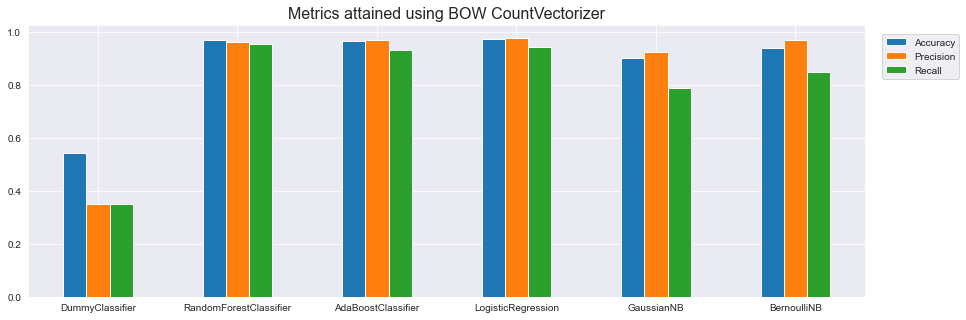

In [33]:
res_df.plot.bar(rot=0, figsize=(15,5))
plt.xticks([0, 1, 2, 3, 4, 5], res_df.clf)
plt.legend(loc=(1.02, 0.8))
plt.title('Metrics attained using BOW CountVectorizer', fontsize=16)
plt.show()

### Metrics using TF-IDF

In [34]:
clfs = [DummyClassifier(strategy = 'stratified'),
        RandomForestClassifier(), 
        AdaBoostClassifier(),
        LogisticRegression(),
        GaussianNB(),
        BernoulliNB()
       ]
res_df_tf = pd.DataFrame(columns=['clf', 'Accuracy', 'Precision', 'Recall'])
for clf in clfs:
    scoring = ['accuracy', 'precision', 'recall']
    final_score = cross_validate(clf, X_tf_train.toarray(), y_tf_train, cv=5, scoring=scoring)
    res_df_tf = res_df_tf.append({'clf':clf.__class__.__name__, 
                            'Accuracy':final_score['test_accuracy'].mean(),
                           'Precision':final_score['test_precision'].mean(),
                           'Recall':final_score['test_recall'].mean()}, ignore_index=True)
res_df_tf

,clf,Accuracy,Precision,Recall
0,DummyClassifier,0.544121,0.348412,0.346909
1,RandomForestClassifier,0.970682,0.962288,0.953728
2,AdaBoostClassifier,0.964955,0.970987,0.927686
3,LogisticRegression,0.968352,0.972934,0.935718
4,GaussianNB,0.897195,0.888072,0.808535
5,BernoulliNB,0.938259,0.972049,0.848163


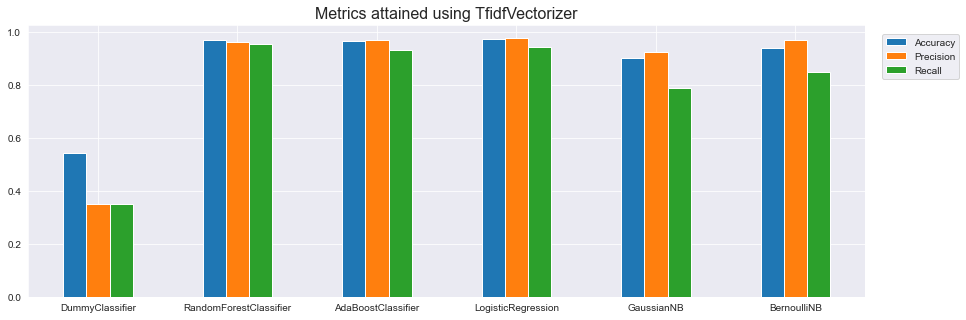

In [35]:
res_df.plot.bar(rot=0, figsize=(15,5))
plt.xticks([0, 1, 2, 3, 4, 5], res_df.clf)
plt.legend(loc=(1.02, 0.8))
plt.title('Metrics attained using TfidfVectorizer', fontsize=16)
plt.show()

### The metrics are pretty much the same using BOW or TF-IDF vectorization. Since I would prefer having higher recall > precision, I would select Random Forest classifier as my go-to model. 


### Saving a Random Forest Classifier Model for deployment using Docker


In [36]:
rf_clf = RandomForestClassifier()

In [37]:
final_score = cross_validate(rf_clf, X_tf_train.toarray(), y_tf_train, cv=5, scoring='accuracy')
final_score['test_score'].mean()

0.9700995840458256

In [38]:
rf_clf.fit(X_tf_train.toarray(), y_tf_train)
pred = rf_clf.predict(X_tf_test.toarray())
rf_clf.score(X_tf_test.toarray(), y_tf_test)

0.9743788819875776

In [39]:
pred_proba = rf_clf.predict_proba(X_tf_test.toarray())
pred_proba

array([[1.        , 0.        ],
       [0.07      , 0.93      ],
       [1.        , 0.        ],
       ...,
       [0.01      , 0.99      ],
       [0.83327562, 0.16672438],
       [1.        , 0.        ]])

In [40]:
import pickle
filename = 'rf_model.pkl'
pickle.dump(rf_clf, open(filename, 'wb'))

In [41]:
filename1 = 'tf.pkl'
pickle.dump(tf, open(filename1, 'wb'))

In [46]:
X_tf_test

<2576x9000 sparse matrix of type '<class 'numpy.float64'>'
	with 27825 stored elements in Compressed Sparse Row format>